# Loss(criterion) Function in Deep Learning

In [ ]:
import torch
from torch import nn
import torchvision
# from torchvision.datasets import CIFAR10, MNIST
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader, Dataset
from torchsummary import summary

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import math
import cv2 as cv
from pathlib import Path
import gc

In [ ]:
import io
import glob
import os
from shutil import move
from os.path import join
from os import rmdir

In [ ]:
!pip install -q torchmetrics
from torchmetrics.classification import MulticlassAccuracy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 517.2/517.2 KB 9.3 MB/s eta 0:00:00


## Device Agnostic code

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Get datasets

In [ ]:
datasset_url = "http://cs231n.stanford.edu/tiny-imagenet-200.zip"
# create a Path object with the path to the file
dataset_path = Path('tiny-imagenet-200.zip')

if dataset_path.is_file() == True:
  print("Skip downlod because already exists.")

else:
  print("Starting to downlod datasets | :)")
  !wget {datasset_url}
  print("extract zipfolder of imagenet 'tiny-imagenet-200.zip'")
  !unzip 'tiny-imagenet-200.zip'

Streaming output truncated to the last 5000 lines.
  inflating: tiny-imagenet-200/val/images/val_3979.JPEG  
  inflating: tiny-imagenet-200/val/images/val_3963.JPEG  
  inflating: tiny-imagenet-200/val/images/val_7199.JPEG  
  inflating: tiny-imagenet-200/val/images/val_2752.JPEG  
  inflating: tiny-imagenet-200/val/images/val_9687.JPEG  
  inflating: tiny-imagenet-200/val/images/val_9407.JPEG  
  inflating: tiny-imagenet-200/val/images/val_3603.JPEG  
  inflating: tiny-imagenet-200/val/images/val_3412.JPEG  
  inflating: tiny-imagenet-200/val/images/val_6982.JPEG  
  inflating: tiny-imagenet-200/val/images/val_8496.JPEG  
  inflating: tiny-imagenet-200/val/images/val_7332.JPEG  
  inflating: tiny-imagenet-200/val/images/val_9241.JPEG  
  inflating: tiny-imagenet-200/val/images/val_4196.JPEG  
  inflating: tiny-imagenet-200/val/images/val_5980.JPEG  
  inflating: tiny-imagenet-200/val/images/val_6697.JPEG  
  inflating: tiny-imagenet-200/val/images/val_9969.JPEG  
  inflating: tiny-ima

## Preprocess the row datasets

In [ ]:
print("Pre-process Extracted Raw Datasets")

target_dataset_folder = './tiny-imagenet-200/val/'

val_dictonary = {}
try:
  with open(target_dataset_folder + 'val_annotations.txt', 'r') as f:
      for file_line in f.readlines():
          line_split = file_line.split('\t')
          val_dictonary[line_split[0]] = line_split[1]
          
  images_path = glob.glob(target_dataset_folder + 'images/*')
  images_path[0].split('/')[-1]
  for image_path in images_path:
      image_file = image_path.split('/')[-1]
      image_folder = val_dictonary[image_file]
      if not os.path.exists(target_dataset_folder + str(image_folder)):
          os.mkdir(target_dataset_folder + str(image_folder))
          
  for image_path in images_path:
      image_file = image_path.split('/')[-1]
      image_folder = val_dictonary[image_file]
      destination = target_dataset_folder + str(image_folder) + '/' + str(image_file)
      move(image_path, destination)
      
  os.remove('./tiny-imagenet-200/val/val_annotations.txt')
  rmdir('./tiny-imagenet-200/val/images')
except:
  print("Pre process done before or else unable to process further")
print("pre process complited")

Pre-process Extracted Raw Datasets
pre process complited


## get datasets

In [ ]:
# define transforms
transform = transforms.Compose([ transforms.Resize((32,32)),
                                 transforms.ToTensor(),
                                 transforms.Normalize( mean=[0.4914, 0.4822, 0.4465],
                                                       std=[0.2023, 0.1994, 0.2010],
                                                     ),
                              ])


train_data = torchvision.datasets.ImageFolder( root='tiny-imagenet-200/train',
                                               transform=transform,
                                             )

test_data = torchvision.datasets.ImageFolder( root='tiny-imagenet-200/val',
                                                 transform=transform,
                                               )

In [ ]:
len(train_data), len(test_data)

(100000, 10000)

In [ ]:
data = list(range(0, len(train_data), 2))
new_train_data = torch.utils.data.Subset(train_data, data)

In [ ]:
len(new_train_data)

50000

In [ ]:
labels = train_data.class_to_idx  # getting class -> index map
labels = dict(map(reversed, labels.items())) 

## Visualize data

In [ ]:
image, label = train_data[0]
print(f"image_shape: {image.shape}")

image_shape: torch.Size([3, 32, 32])


Text(0.5, 1.0, 'n01443537')

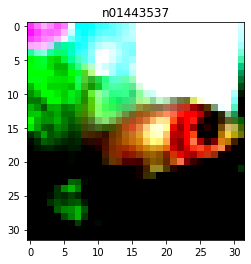

In [ ]:
plt.imshow(image.permute(1,2,0).squeeze())
plt.title(labels[label])

## Make Dataloader

In [ ]:
BATCH_SIZE = 32
train_dataloader = DataLoader(dataset = new_train_data, batch_size = BATCH_SIZE, shuffle = True, drop_last = True)
test_dataloader = DataLoader(dataset = test_data, batch_size = BATCH_SIZE, shuffle = True, drop_last = True)

print(f"total {len(train_dataloader)} of train dataloader batches of batch size {BATCH_SIZE}")
print(f"total {len(test_dataloader)} of test dataloader batches of batch size {BATCH_SIZE}")

total 1562 of train dataloader batches of batch size 32
total 312 of test dataloader batches of batch size 32


## Bulid the Base model

In [ ]:
# ResNet 18 model

class ResBlock(nn.Module):
    def __init__(self, in_channels, out_channels, downsample):
        super().__init__()
        if downsample:
            self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1)
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=2),
                nn.BatchNorm2d(out_channels)
            )
        else:
            self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1)
            self.shortcut = nn.Sequential()

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()

    def forward(self, input):
        shortcut = self.shortcut(input)
        input = self.relu(self.bn1(self.conv1(input)))
        input = self.relu(self.bn2(self.conv2(input)))
        input = input + shortcut
        return self.relu(input)


class ResNet18(nn.Module):
  def __init__(self, in_channels, resblock, outputs):
        super().__init__()
        self.layer0 = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=7, stride=2, padding=3),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )

        self.layer1 = nn.Sequential(
            resblock(64, 64, downsample=False),
            resblock(64, 64, downsample=False)
        )

        self.layer2 = nn.Sequential(
            resblock(64, 128, downsample=True),
            resblock(128, 128, downsample=False)
        )

        self.layer3 = nn.Sequential(
            resblock(128, 256, downsample=True),
            resblock(256, 256, downsample=False)
        )


        self.layer4 = nn.Sequential(
            resblock(256, 512, downsample=True),
            resblock(512, 512, downsample=False)
        )

        self.gap = nn.AdaptiveAvgPool2d(1)
        self.flat = nn.Flatten()
        self.fc = nn.Linear(512, outputs)

  def forward(self, input):
        input = self.layer0(input)
        input = self.layer1(input)
        input = self.layer2(input)
        input = self.layer3(input)
        input = self.layer4(input)
        # print(input.shape)
        input = self.gap(input)
        # print(input.shape)
        input = self.flat(input)
        # print(input.shape)
        input = self.fc(input)

        return input

In [ ]:
resnet18 = ResNet18(3, ResBlock, outputs = 200).to(device)
# summary(resnet18, (3,32,32))
resnet18

ResNet18(
  (layer0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
  )
  (layer1): Sequential(
    (0): ResBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (shortcut): Sequential()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (1): ResBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (shortcut): Sequential()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05

## Train and Test step

In [ ]:
# train
def train_loop(model: torch.nn.Module, dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module, optimizer: torch.optim.Optimizer,
               accuracy_fn, device: torch.device = device):
  
  train_loss, train_acc = 0, 0
  for batch, (x_train, y_train) in enumerate(dataloader):
    
    if device == 'cuda':
      x_train, y_train = x_train.to(device), y_train.to(device)

    x_train.requires_grad = True

    model.train()
    # 1. Forward step
    pred = model(x_train)

    # 2. Loss
    loss = loss_fn(pred, y_train)
    

    # 3. Grad zerostep
    optimizer.zero_grad()

    # 4. Backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    acc = accuracy_fn(y_train, torch.argmax(pred, dim=1))
    train_loss += loss
    train_acc += acc

  train_loss /= len(dataloader)
  train_acc /= len(dataloader)

  return train_loss, train_acc


# test
def test_loop(model: torch.nn.Module, dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module, accuracy_fn, 
              device: torch.device = device):
  
  test_loss, test_acc = 0, 0
  model.eval()
  with torch.inference_mode():
    for x_test, y_test in dataloader:

      if device == 'cuda':
        x_test, y_test = x_test.to(device), y_test.to(device)

      # 1. Forward
      test_pred = model(x_test)
      
      # 2. Loss and accuray
      test_loss += loss_fn(test_pred, y_test)
      test_acc += accuracy_fn(y_test, torch.argmax(test_pred, dim=1))

    test_loss /= len(dataloader)
    test_acc /= len(dataloader)

  return test_loss, test_acc

## Plot graph of Loss and Accuray

In [ ]:
def plot_graph(train_losses, test_losses, train_accs, test_accs):
  plt.figure(figsize = (20, 8))
  plt.subplot(1, 2, 1)
  plt.plot(range(len(train_losses)), train_losses, label = "Train Loss")
  plt.plot(range(len(test_losses)), test_losses, label = "Test Loss")
  plt.legend()
  plt.xlabel("Epoches")
  plt.ylabel("Loss")
  # plt.show()

  plt.subplot(1, 2, 2)
  plt.plot(range(len(train_accs)), train_accs, label = "Train Accuracy")
  plt.plot(range(len(test_accs)), test_accs, label = "Test Accuracy")
  plt.legend()
  plt.xlabel("Epoches")
  plt.ylabel("Accuracy")
  plt.show()

## Accuracy Function

In [ ]:
# accuray
accuracy_fn = MulticlassAccuracy(num_classes = 200).to(device)

# Different Losses function

## CrossEntropyLoss

In [ ]:
# loss
def cross_entropy_loss(logits_of_y_preds:torch.Tensor, true_y:torch.Tensor):

  y_pred_exp = logits_of_y_preds.exp()

  total_y_pred = y_pred_exp.sum(-1)

  log_y_pred = total_y_pred.log()

  sub_y_preds = log_y_pred.unsqueeze(-1)
  # sub_y_preds = logits_of_y_preds.exp().sum(-1).log().unsqueeze(-1)

  logits_of_y_preds = logits_of_y_preds - sub_y_preds 

  return -logits_of_y_preds[range(true_y.shape[0]), true_y].mean()

### Train model with cross entropy loss

In [ ]:
gc.collect()
torch.cuda.empty_cache()
epoches = 5

loss_fn = cross_entropy_loss
# loss_fn = nn.CrossEntropyLoss()

resnet18_train_loss, resnet18_test_loss = [], []
resnet18_train_accs, resnet18_test_accs = [], []


torch.manual_seed(64)
torch.cuda.manual_seed(64)
resnet18 = ResNet18(3, ResBlock, outputs = 200).to(device)

# SGD with momentum
# optimizer = torch.optim.SGD(params = resnet18.parameters(), lr = 0.1, momentum = 0.3)

# Adam as optimizer
optimizer = torch.optim.Adam(params = resnet18.parameters(), lr = 0.0003, 
                             betas = (0.9, 0.99))


torch.manual_seed(64)
torch.cuda.manual_seed(64)
for epoch in tqdm(range(epoches)):

  train_loss, train_acc = train_loop(model = resnet18, dataloader = train_dataloader,
                                    loss_fn = loss_fn, optimizer = optimizer,
                                    accuracy_fn = accuracy_fn, device = device)
  
  test_loss, test_acc = test_loop(model = resnet18, dataloader = test_dataloader,
                                  loss_fn = loss_fn, accuracy_fn = accuracy_fn,
                                  device = device)
  
  resnet18_train_loss.append(train_loss.item())
  resnet18_test_loss.append(test_loss.item())
  resnet18_train_accs.append(train_acc.item())
  resnet18_test_accs.append(test_acc.item())

  print(f"Epoch: {epoch+1}  Train Loss: {train_loss:.4f} | Test Loss: {test_loss:.4f} | Train Accuray: {train_acc:.4f} | Test Accuracy: {test_acc:.4f}")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1  Train Loss: 4.7711 | Test Loss: 4.4392 | Train Accuray: 0.0069 | Test Accuracy: 0.0038
Epoch: 2  Train Loss: 4.1556 | Test Loss: 4.0311 | Train Accuray: 0.0171 | Test Accuracy: 0.0047
Epoch: 3  Train Loss: 3.8001 | Test Loss: 3.9476 | Train Accuray: 0.0249 | Test Accuracy: 0.0054
Epoch: 4  Train Loss: 3.5315 | Test Loss: 3.7686 | Train Accuray: 0.0312 | Test Accuracy: 0.0061
Epoch: 5  Train Loss: 3.2710 | Test Loss: 3.6820 | Train Accuray: 0.0374 | Test Accuracy: 0.0062


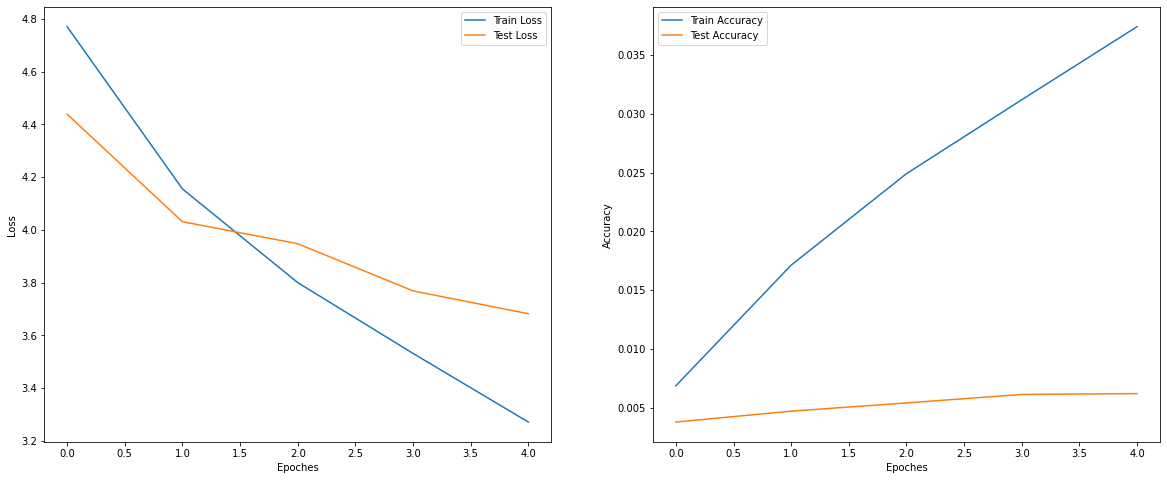

In [ ]:
plot_graph(resnet18_train_loss, resnet18_test_loss, resnet18_train_accs, resnet18_test_accs)

In [ ]:
!nvidia-smi

Tue Feb 28 16:24:34 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P0    28W /  70W |   4843MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Triplet Loss

In [ ]:
import os
import pandas as pd
from pathlib import Path

In [ ]:
train_data_path = Path('tiny-imagenet-200/train/')
test_data_path = Path('tiny-imagenet-200/val/')
train_data_path,test_data_path

(PosixPath('tiny-imagenet-200/train'), PosixPath('tiny-imagenet-200/val'))

In [ ]:
train_data_path_list = list(train_data_path.glob("*/*/*.JPEG"))
test_data_path_list = list(test_data_path.glob("*/*.JPEG"))

In [ ]:
image_name = []
class_name = []
for i in train_data_path_list:
    x = str(i).split("/")
    # print(x)
    image_name.append(x[4])
    class_name.append(x[2])

data_dict = {'image_name':image_name , 'class_name': class_name}
     
df = pd.DataFrame(data_dict)
df.to_csv('train_data.csv',index=False)

In [ ]:
image_name = []
class_name = []
for i in test_data_path_list:
    x = str(i).split("/")
    # print(x)
    image_name.append(x[3])
    class_name.append(x[2])

data_dict = {'image_name':image_name , 'class_name': class_name}
     
df = pd.DataFrame(data_dict)
df.to_csv('test_data.csv',index=False)

In [ ]:
import random
train_data= pd.read_csv('train_data.csv')
train_data_path = './tiny-imagenet-200/train/'

In [ ]:
class ImageNet(Dataset):
    def __init__(self, df, train=True, transform=None):
        self.is_train = train
        self.transform = transform
        self.to_pil = transforms.ToPILImage()
        
        if self.is_train:            
            self.images = df.iloc[:, 1:].values.astype(np.uint8)
            self.labels = df.iloc[:, 0].values
            self.index = df.index.values
        else:
            self.images = df.values.astype(np.uint8)
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, item):
        anchor_img = self.images[item].reshape(28, 28, 1)
        
        if self.is_train:
            anchor_label = self.labels[item]

            positive_list = self.index[self.index!=item][self.labels[self.index!=item]==anchor_label]

            positive_item = random.choice(positive_list)
            positive_img = self.images[positive_item].reshape(28, 28, 1)
            
            negative_list = self.index[self.index!=item][self.labels[self.index!=item]!=anchor_label]
            negative_item = random.choice(negative_list)
            negative_img = self.images[negative_item].reshape(28, 28, 1)
            
            if self.transform:
                anchor_img = self.transform(self.to_pil(anchor_img))
                positive_img = self.transform(self.to_pil(positive_img))
                negative_img = self.transform(self.to_pil(negative_img))
            
            return anchor_img, positive_img, negative_img, anchor_label
        
        else:
            if self.transform:
                anchor_img = self.transform(self.to_pil(anchor_img))
            return anchor_img

In [ ]:
train_ds = ImageNet(train_data, 
                    train=True,
                    transform=transforms.Compose([
                        transforms.Resize((32,32)),
                        transforms.ToTensor()
                    ]))
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)


ValueError: ignored

In [ ]:
test_ds = ImageNet(test_df, train=False, transform=transforms.Compose([
                                                                          transforms.Resize((32,32)),
                                                                          transforms.ToTensor()
                                                                      ]))
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

NameError: ignored

In [ ]:
class TripletLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(TripletLoss, self).__init__()
        self.margin = margin
        
    def calc_euclidean(self, x1, x2):
        return (x1 - x2).pow(2).sum(1)
    
    def forward(self, anchor: torch.Tensor, positive: torch.Tensor, negative: torch.Tensor) -> torch.Tensor:
        distance_positive = self.calc_euclidean(anchor, positive)
        distance_negative = self.calc_euclidean(anchor, negative)
        losses = torch.relu(distance_positive - distance_negative + self.margin)

        return losses.mean()

### train model with triplet loss

In [ ]:
gc.collect()
torch.cuda.empty_cache()
epoches = 5

loss_fn = torch.jit.script(TripletLoss())
# loss_fn = nn.CrossEntropyLoss()

resnet18_train_loss, resnet18_test_loss = [], []
resnet18_train_accs, resnet18_test_accs = [], []


torch.manual_seed(64)
torch.cuda.manual_seed(64)
resnet18 = ResNet18(3, ResBlock, outputs = 200).to(device)

# SGD with momentum
# optimizer = torch.optim.SGD(params = resnet18.parameters(), lr = 0.1, momentum = 0.3)

# Adam as optimizer
optimizer = torch.optim.Adam(params = resnet18.parameters(), lr = 0.0003, 
                             betas = (0.9, 0.99))


torch.manual_seed(64)
torch.cuda.manual_seed(64)
for epoch in tqdm(range(epoches)):

  train_loss, train_acc = train_loop(model = resnet18, dataloader = train_dataloader,
                                    loss_fn = loss_fn, optimizer = optimizer,
                                    accuracy_fn = accuracy_fn, device = device)
  
  test_loss, test_acc = test_loop(model = resnet18, dataloader = test_dataloader,
                                  loss_fn = loss_fn, accuracy_fn = accuracy_fn,
                                  device = device)
  
  resnet18_train_loss.append(train_loss.item())
  resnet18_test_loss.append(test_loss.item())
  resnet18_train_accs.append(train_acc.item())
  resnet18_test_accs.append(test_acc.item())

  print(f"Epoch: {epoch+1}  Train Loss: {train_loss:.4f} | Test Loss: {test_loss:.4f} | Train Accuray: {train_acc:.4f} | Test Accuracy: {test_acc:.4f}")

  0%|          | 0/5 [00:00<?, ?it/s]

RuntimeError: ignored

## CentelLoss

In [ ]:
def centeross(y_preds:torch.Tensor,y_true:torch.Tensor):

    num_classes = 200
    feat_dim = 200
    device=device
    # ls =None
    x = y_preds.to(device)

    J1 = y_true.to(device)
    # if device == "cuda":
    #     centers = nn.Parameter(torch.randn(num_classes, feat_dim).cuda())
    # else:
    centers = nn.Parameter(torch.randn(num_classes, feat_dim).cuda)
    batch_size = x.size(0)
    dist_1 = torch.pow(x, 2).sum(dim=1, keepdim=True).expand(batch_size, num_classes)
    dist_2 = torch.pow(centers, 2).sum(dim=1, keepdim=True).expand(num_classes, batch_size).t()
    distmat = dist_1 + dist_2
    distmat.addmm_(x, centers.t(), beta=1, alpha=-2)
    classes = torch.arange(num_classes)
    final_classes = classes.long().to(device)
    
    if device == "cuda":
        final_classes = final_classes.cuda()
    J1 = J1.unsqueeze(1).expand(batch_size, num_classes)
    mask = J1.eq(final_classes.expand(batch_size, num_classes))

    dist = distmat * mask.float()
    # loss = 
    return dist.clamp(min=1e-12, max=1e+12).sum() / batch_size


### Model train with centrel loss

In [ ]:
gc.collect()
torch.cuda.empty_cache()
epoches = 5

loss_fn = centeross
# loss_fn = nn.CrossEntropyLoss()

resnet18_train_loss, resnet18_test_loss = [], []
resnet18_train_accs, resnet18_test_accs = [], []


torch.manual_seed(64)
torch.cuda.manual_seed(64)
resnet18 = ResNet18(3, ResBlock, outputs = 200).to(device)

# SGD with momentum
# optimizer = torch.optim.SGD(params = resnet18.parameters(), lr = 0.1, momentum = 0.3)

# Adam as optimizer
optimizer = torch.optim.Adam(params = resnet18.parameters(), lr = 1e-4)


torch.manual_seed(64)
torch.cuda.manual_seed(64)
for epoch in tqdm(range(epoches)):

  train_loss, train_acc = train_loop(model = resnet18, dataloader = train_dataloader,
                                    loss_fn = loss_fn, optimizer = optimizer,
                                    accuracy_fn = accuracy_fn, device = device)
  
  test_loss, test_acc = test_loop(model = resnet18, dataloader = test_dataloader,
                                  loss_fn = loss_fn, accuracy_fn = accuracy_fn,
                                  device = device)
  
  resnet18_train_loss.append(train_loss.item())
  resnet18_test_loss.append(test_loss.item())
  resnet18_train_accs.append(train_acc.item())
  resnet18_test_accs.append(test_acc.item())

  print(f"Epoch: {epoch+1}  Train Loss: {train_loss:.4f} | Test Loss: {test_loss:.4f} | Train Accuray: {train_acc:.4f} | Test Accuracy: {test_acc:.4f}")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1  Train Loss: 202.8013 | Test Loss: 202.2077 | Train Accuray: 0.0004 | Test Accuracy: 0.0001
Epoch: 2  Train Loss: 200.9506 | Test Loss: 203.7187 | Train Accuray: 0.0002 | Test Accuracy: 0.0001
Epoch: 3  Train Loss: 200.9510 | Test Loss: 201.9545 | Train Accuray: 0.0001 | Test Accuracy: 0.0001
Epoch: 4  Train Loss: 201.0740 | Test Loss: 201.9410 | Train Accuray: 0.0001 | Test Accuracy: 0.0001
Epoch: 5  Train Loss: 201.0635 | Test Loss: 204.0206 | Train Accuray: 0.0001 | Test Accuracy: 0.0002


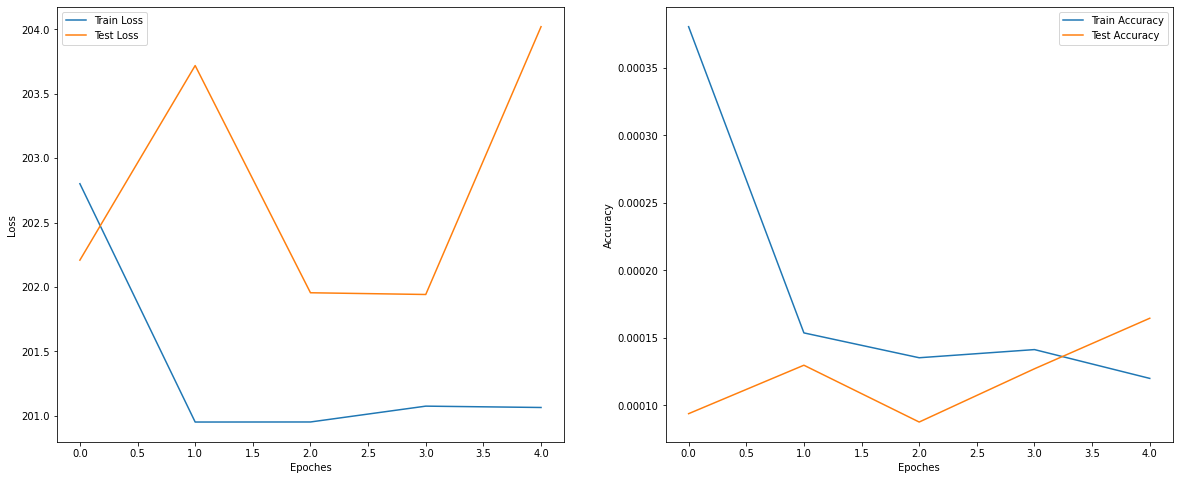

In [ ]:
plot_graph(resnet18_train_loss, resnet18_test_loss, resnet18_train_accs, resnet18_test_accs)